# Entraînement et Inférence Latent Diffusion sur Kaggle

Ce notebook implémente l'entraînement d'un modèle de diffusion latente sur le dataset CelebA-HQ, suivi d'une inférence simple (génération inconditionnelle).

## Pré-requis
Le dataset doit être ajouté à l'environnement Kaggle (ex: `badasstechie/celebahq-resized-256x256`).
Le chemin attendu est `/kaggle/input/celebahq-resized-256x256`.

In [5]:
# 1. Installation et Imports
!pip install -q diffusers accelerate transformers wandb

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import glob
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
from diffusers import AutoencoderKL, UNet2DModel, DDPMScheduler
from accelerate import Accelerator
import wandb

print("Bibliothèques installées et importées.")

Bibliothèques installées et importées.


In [ ]:
# Connexion automatique à WandB via Kaggle Secrets
try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    wandb_key = user_secrets.get_secret("WANDB_API_KEY")
    wandb.login(key=wandb_key)
    print("✅ Connecté à WandB via Kaggle Secrets.")
except Exception as e:
    print(f"⚠️ Impossible de se connecter automatiquement à WandB : {e}")
    print("Veuillez vous assurer que la clé 'WANDB_API_KEY' est ajoutée dans les Add-ons -> Secrets.")

In [6]:
# 2. Dataset et Transformations
class CelebAHQDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        # Recherche récursive des images
        self.image_paths = glob.glob(os.path.join(root_dir, "**", "*.jpg"), recursive=True) + \
                           glob.glob(os.path.join(root_dir, "**", "*.png"), recursive=True)
        
        print(f"Found {len(self.image_paths)} images in {root_dir}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return self.__getitem__((idx + 1) % len(self))
            
        if self.transform:
            image = self.transform(image)
            
        return image

def get_transforms(image_size=256):
    return transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        # Normalisation pour RGB (3 canaux) vers [-1, 1]
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) 
    ])

In [14]:
# 3. Modèles (VAE et UNet)
def get_vae(model_id="runwayml/stable-diffusion-v1-5"):
    print(f"Loading VAE from {model_id}...")
    vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae")
    vae.eval()
    vae.requires_grad_(False) # Freeze VAE
    return vae

def get_unet(image_size=32, in_channels=4, out_channels=4):
    # image_size ici est la taille du latent (256 / 8 = 32)
    print(f"Creating UNet2DModel with input/output channels={in_channels}, latent_size={image_size}...")
    unet = UNet2DModel(
        sample_size=image_size,
        in_channels=in_channels,
        out_channels=out_channels,
        layers_per_block=2,
        block_out_channels=(128, 128, 256, 256, 512, 512),
        down_block_types=(
            "DownBlock2D", "DownBlock2D", "DownBlock2D", "DownBlock2D", "AttnDownBlock2D", "DownBlock2D",
        ),
        up_block_types=(
            "UpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D", "UpBlock2D", "UpBlock2D",
        ),
    )
    
    # Calcul et affichage du nombre de paramètres
    num_params = sum(p.numel() for p in unet.parameters() if p.requires_grad)
    print(f"--> Modèle UNet initialisé avec {num_params:,} paramètres.")
    
    return unet


In [8]:
# 5. Inférence Simple (Sans SMC)
def simple_inference(unet, num_samples=4, save_path=None):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Si unet est enveloppé par accelerator, on peut l'utiliser directement ou le déballer
    if isinstance(unet, torch.nn.parallel.DistributedDataParallel):
        unet = unet.module
    unet.to(device)
    unet.eval()
    
    vae = get_vae().to(device)
    
    # Scheduler pour l'inférence (Même config que train)
    scheduler = DDPMScheduler(
        num_train_timesteps=1000,
        beta_schedule="scaled_linear",
        prediction_type="epsilon",
        clip_sample=False
    )
    scheduler.set_timesteps(1000)
    
    # 1. Générer du bruit initial (Latents)
    latents = torch.randn((num_samples, 4, 32, 32), device=device)
    
    # Indices pour capturer la progression (0%, 25%, 50%, 75%, 100%)
    capture_indices = [0, 250, 500, 750] 
    captured_images = []
    
    print("Début de l'inférence...")
    for i, t in enumerate(tqdm(scheduler.timesteps)):
        # Capture intermédiaire
        if i in capture_indices:
            with torch.no_grad():
                # Décodage rapide pour visualisation
                temp_latents = latents / vae.config.scaling_factor
                decoded = vae.decode(temp_latents).sample
                decoded = (decoded / 2 + 0.5).clamp(0, 1)
                decoded = decoded.cpu().permute(0, 2, 3, 1).numpy()
                captured_images.append(decoded)

        with torch.no_grad():
            # Prédiction du bruit
            noise_pred = unet(latents, t).sample
            
            # Step du scheduler (retrait du bruit)
            latents = scheduler.step(noise_pred, t, latents).prev_sample
            
    # Capture finale (100%)
    with torch.no_grad():
        latents = latents / vae.config.scaling_factor
        images = vae.decode(latents).sample
        images = (images / 2 + 0.5).clamp(0, 1)
        images = images.cpu().permute(0, 2, 3, 1).numpy()
        captured_images.append(images)
        
    # 3. Affichage : Grille (num_samples x 5)
    num_steps = len(captured_images)
    fig, axes = plt.subplots(num_samples, num_steps, figsize=(3 * num_steps, 3 * num_samples))
    
    # Gestion du cas num_samples=1
    if num_samples == 1:
        axes = axes.reshape(1, -1)
        
    for i in range(num_samples):
        for j in range(num_steps):
            axes[i, j].imshow(captured_images[j][i])
            axes[i, j].axis("off")
            if i == 0:
                step_label = f"Step {capture_indices[j]}" if j < len(capture_indices) else "Final"
                axes[i, j].set_title(step_label)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
        print(f"Saved visualization to {save_path}")
        plt.close(fig)
    else:
        plt.show()

In [18]:
# 4. Entraînement script
import shutil

def train_loop(num_epochs=1, resume_from_checkpoint=None, start_epoch=0):
    # Configuration
    config = {
        "data_dir": "/kaggle/input/celebahq-resized-256x256", # Chemin Kaggle typique
        "output_dir": "checkpoints",
        "batch_size": 32,
        "epochs": num_epochs, # Ajuster selon le temps disponible (GPU quota)
        "lr": 1e-4,
        "mixed_precision": "fp16",
        "gradient_accumulation_steps": 1
    }
    
    # Vérification du chemin dataset (fallback si local pour test)
    if not os.path.exists(config["data_dir"]):
        print(f"Warning: {config['data_dir']} not found. Checking local ./data...")
        if os.path.exists("./data"):
            config["data_dir"] = "./data"
        else:
            print("Error: Dataset not found.")
            return

    # Initialisation de l'Accelerator avec WandB
    accelerator = Accelerator(
        mixed_precision=config["mixed_precision"],
        gradient_accumulation_steps=config["gradient_accumulation_steps"],
        log_with="wandb"
    )

    if accelerator.is_main_process:
        os.makedirs(config["output_dir"], exist_ok=True)
        # Initialisation du projet WandB
        accelerator.init_trackers("celebahq-latent-diffusion", config=config)

    # Load Models
    vae = get_vae()
    
    if resume_from_checkpoint:
        print(f"🔄 Reprise de l'entraînement depuis : {resume_from_checkpoint}")
        # Chargement du UNet pré-entraîné
        unet = UNet2DModel.from_pretrained(resume_from_checkpoint)
    else:
        unet = get_unet(image_size=32)
    
    # Scheduler Configuration 
    noise_scheduler = DDPMScheduler(
        num_train_timesteps=1000,
        beta_schedule="scaled_linear",
        prediction_type="epsilon",
        clip_sample=False # Important pour latent diffusion
    )

    # Freeze VAE and move to device
    vae.to(accelerator.device)
    vae.eval()

    # Optimizer
    optimizer = torch.optim.AdamW(unet.parameters(), lr=config["lr"])

    # Dataset & Dataloader
    dataset = CelebAHQDataset(root_dir=config["data_dir"], transform=get_transforms(256))
    
    # IMPORTANT : num_workers=0 pour éviter les blocages sur macOS ou dans certains notebooks
    train_dataloader = DataLoader(
        dataset, batch_size=config["batch_size"], shuffle=True, num_workers=0, pin_memory=True
    )

    # Prepare
    unet, optimizer, train_dataloader = accelerator.prepare(
        unet, optimizer, train_dataloader
    )

    # Training Loop
    global_step = 0
    
    print(f"🚀 Démarrage de l'entraînement de l'époque {start_epoch} à {start_epoch + config['epochs'] - 1}")
    
    for epoch in range(start_epoch, start_epoch + config["epochs"]):
        unet.train()
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch # Accelerator gère le device
            
            # Encode images to latents
            with torch.no_grad():
                latents = vae.encode(clean_images).latent_dist.sample()
                latents = latents * vae.config.scaling_factor

            # Sample noise
            noise = torch.randn_like(latents)
            bs = latents.shape[0]
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bs,), device=latents.device).long()

            # Add noise
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            # Predict noise
            with accelerator.accumulate(unet):
                noise_pred = unet(noisy_latents, timesteps).sample
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)
                optimizer.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            progress_bar.set_postfix(loss=loss.item())
            global_step += 1
            
            # Log de la loss dans WandB
            accelerator.log({"train_loss": loss.item()}, step=global_step)

        # Save Checkpoint & Inference
        if accelerator.is_main_process:
            # Sauvegarde tous les 5 epochs OU à la dernière epoch
            if (epoch + 1) % 5 == 0 or epoch == start_epoch + config["epochs"] - 1:
                # Utilisation de unwrap_model pour sauvegarder proprement
                unwrapped_unet = accelerator.unwrap_model(unet)
                save_path = os.path.join(config["output_dir"], f"checkpoint-epoch-{epoch}")
                unwrapped_unet.save_pretrained(save_path)
                print(f"Saved model to {save_path}")
            
            # Inférence de visualisation (à chaque epoch pour le suivi)
            # On utilise unwrap_model ici aussi pour l'inférence
            unwrapped_unet = accelerator.unwrap_model(unet)
            print(f"Running inference visualization for epoch {epoch}...")
            vis_path = os.path.join(config["output_dir"], f"vis_epoch_{epoch}.png")
            simple_inference(unwrapped_unet, num_samples=4, save_path=vis_path)
            
            # Log de l'image dans WandB
            accelerator.log({"inference_samples": wandb.Image(vis_path)}, step=global_step)

    accelerator.end_training()
    print("Training finished.")
    return unet # Retourne le modèle entraîné (wrapped)

In [19]:
# Lancer l'entraînement (Exemple standard)
# trained_unet = train_loop(num_epochs=100)

# --- POUR REPRENDRE L'ENTRAÎNEMENT ---
# Exemple : Reprendre au checkpoint 45 pour 100 époques supplémentaires
# Assurez-vous que le dossier 'checkpoints/checkpoint-epoch-45' existe.
# Si vous êtes sur Kaggle et que le checkpoint vient d'une session précédente, 
# il faudra peut-être ajuster le chemin (ex: /kaggle/input/mon-dataset-checkpoints/checkpoint-epoch-45)

checkpoint_path = "checkpoint-epoch-44" # Ajustez ce chemin !

if os.path.exists(checkpoint_path):
    print("Reprise de l'entraînement...")
    trained_unet = train_loop(num_epochs=100, resume_from_checkpoint=checkpoint_path, start_epoch=45)
else:
    print(f"Checkpoint non trouvé à {checkpoint_path}. Lancement d'un nouvel entraînement...")
    trained_unet = train_loop(num_epochs=100)

Reprise de l'entraînement...
Error: Dataset not found.


Loading VAE from runwayml/stable-diffusion-v1-5...
Loading image from testimage.jpg...
Loading image from testimage.jpg...
Running 50 steps of inference...
Running 50 steps of inference...


  0%|          | 0/50 [00:00<?, ?it/s]

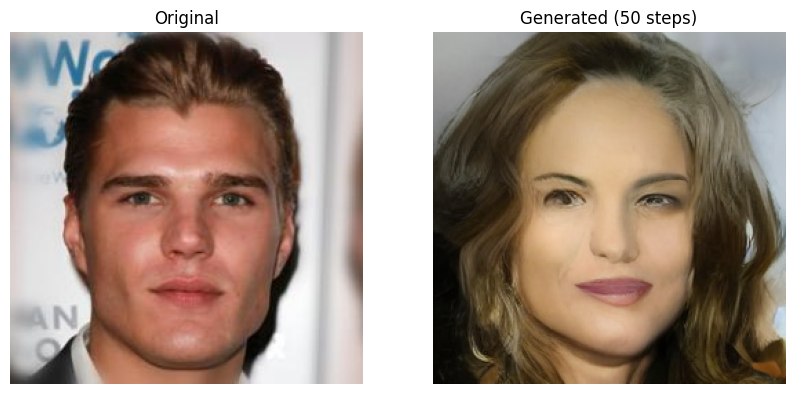

In [ ]:
# Fonction de test sur une image spécifique (Image-to-Image / Variation)
def test_image_inference(image_path, unet, steps=10):
    if not os.path.exists(image_path):
        print(f"Image non trouvée : {image_path}")
        return

    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Gestion du modèle (unwrap si nécessaire)
    if isinstance(unet, torch.nn.parallel.DistributedDataParallel):
        unet = unet.module
    unet.to(device)
    unet.eval()
    
    vae = get_vae().to(device)
    
    # 1. Load & Preprocess
    print(f"Loading image from {image_path}...")
    transform = get_transforms(256)
    original_pil = Image.open(image_path).convert("RGB")
    image_tensor = transform(original_pil).unsqueeze(0).to(device)
    
    # 2. Encode
    with torch.no_grad():
        latents = vae.encode(image_tensor).latent_dist.sample()
        latents = latents * vae.config.scaling_factor
        
    # 3. Setup Scheduler (20 steps)
    scheduler = DDPMScheduler(
        num_train_timesteps=1000,
        beta_schedule="scaled_linear",
        prediction_type="epsilon",
        clip_sample=False
    )
    scheduler.set_timesteps(steps)
    
    # 4. Add Noise (On commence avec du bruit correspondant au premier timestep du scheduler)
    # Cela permet de générer une variation de l'image originale
    noise = torch.randn_like(latents)
    t_start = scheduler.timesteps[0] # Le timestep le plus bruité parmi les 20 sélectionnés
    
    curr_latents = scheduler.add_noise(latents, noise, t_start.unsqueeze(0))
    
    print(f"Running {steps} steps of inference...")
    for t in tqdm(scheduler.timesteps):
        with torch.no_grad():
            noise_pred = unet(curr_latents, t).sample
            curr_latents = scheduler.step(noise_pred, t, curr_latents).prev_sample
            
    # 5. Decode
    with torch.no_grad():
        curr_latents = curr_latents / vae.config.scaling_factor
        result_image = vae.decode(curr_latents).sample
        result_image = (result_image / 2 + 0.5).clamp(0, 1)
        result_image = result_image.cpu().permute(0, 2, 3, 1).numpy()[0]
        
    # 6. Show
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(original_pil)
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.title(f"Generated ({steps} steps)")
    plt.imshow(result_image)
    plt.axis("off")
    plt.show()

# Exemple d'utilisation (à décommenter et adapter avec un vrai chemin)
test_image_path = "testimage.jpg"  
resume_from_checkpoint = "checkpoint-epoch-44"
unet = UNet2DModel.from_pretrained(resume_from_checkpoint)
    if 'trained_unet' in locals():
        test_image_inference(test_image_path, unet, steps=50)

Loading VAE from runwayml/stable-diffusion-v1-5...
Loading Emotion Classifier from dima806/facial_emotions_image_detection...
Loading Emotion Classifier from dima806/facial_emotions_image_detection...
Target: happy (ID: 6)
Loading image from testimage.jpg...
Target: happy (ID: 6)
Loading image from testimage.jpg...
Starting SMC Inference with 4 particles, target='happy'...
Starting SMC Inference with 4 particles, target='happy'...


  0%|          | 0/50 [00:00<?, ?it/s]

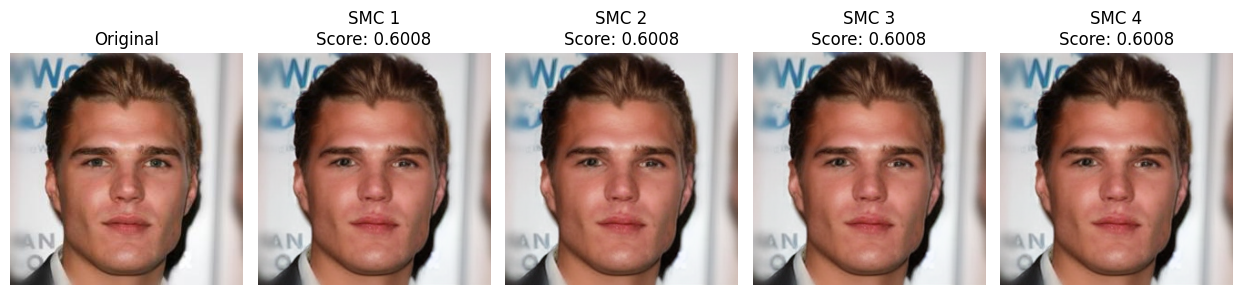

In [72]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

def get_emotion_classifier(model_id="dima806/facial_emotions_image_detection"):
    print(f"Loading Emotion Classifier from {model_id}...")
    processor = AutoImageProcessor.from_pretrained(model_id)
    model = AutoModelForImageClassification.from_pretrained(model_id)
    model.eval()
    model.requires_grad_(False)
    return processor, model

def smc_image_inference(image_path, unet, target_emotion, num_particles=10, steps=50, resample_interval=1, guidance_scale=2.0, noise_strength=0.3, leash=0.0):
    """
    Applique l'inférence SMC pour modifier l'émotion d'une image existante.
    """
    if not os.path.exists(image_path):
        print(f"Image non trouvée : {image_path}")
        return

    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # 1. Load Models
    if isinstance(unet, torch.nn.parallel.DistributedDataParallel):
        unet = unet.module
    unet.to(device)
    unet.eval()
    
    vae = get_vae().to(device)
    processor, classifier = get_emotion_classifier()
    classifier.to(device)
    
    # Check emotion
    id2label = classifier.config.id2label
    label2id = {v.lower(): k for k, v in id2label.items()}
    if target_emotion.lower() not in label2id:
        print(f"Emotion '{target_emotion}' not found. Available: {list(label2id.keys())}")
        return
    target_class_id = label2id[target_emotion.lower()]
    print(f"Target: {target_emotion} (ID: {target_class_id})")

    # 2. Load & Preprocess Image
    print(f"Loading image from {image_path}...")
    transform = get_transforms(256)
    original_pil = Image.open(image_path).convert("RGB")
    image_tensor = transform(original_pil).unsqueeze(0).to(device)
    
    # 3. Encode to Latents
    with torch.no_grad():
        latents = vae.encode(image_tensor).latent_dist.sample()
        latents = latents * vae.config.scaling_factor
        
    # Duplicate latents for particles
    latents = latents.repeat(num_particles, 1, 1, 1)
    
    # 4. Setup Scheduler
    scheduler = DDPMScheduler(
        num_train_timesteps=1000,
        beta_schedule="scaled_linear",
        prediction_type="epsilon",
        clip_sample=False
    )
    scheduler.set_timesteps(steps)
    timesteps = scheduler.timesteps
    
    # 5. Add Noise (Start from t_start)
    noise = torch.randn_like(latents)
    start_idx = int((1.0 - noise_strength) * (len(timesteps) - 1))
    t_start = timesteps[start_idx]
    curr_latents = scheduler.add_noise(latents, noise, t_start)
    
    print(f"Starting SMC Inference with {num_particles} particles, target='{target_emotion}'...")
    
    # Prepare normalization constants from processor
    # Default to ImageNet stats if not found
    image_mean = getattr(processor, "image_mean", [0.485, 0.456, 0.406])
    image_std = getattr(processor, "image_std", [0.229, 0.224, 0.225])
    
    norm_mean = torch.tensor(image_mean, device=device).view(1, 3, 1, 1)
    norm_std = torch.tensor(image_std, device=device).view(1, 3, 1, 1)

    # 6. SMC Loop
    for i, t in enumerate(tqdm(timesteps[start_idx:])):
        # A. Denoise Step
        with torch.no_grad():
            noise_pred = unet(curr_latents, t).sample
            curr_latents = scheduler.step(noise_pred, t, curr_latents).prev_sample
            
            curr_latents = (1 - leash) * curr_latents + leash * latents
            
        # B. Resampling Step
        # On ne resample pas à la toute dernière étape
        if (i + 1) % resample_interval == 0 and (i + 1) < len(timesteps[start_idx:]):
            with torch.no_grad():
                # Decode for classification
                temp_latents = curr_latents / vae.config.scaling_factor
                decoded = vae.decode(temp_latents).sample
                decoded = (decoded / 2 + 0.5).clamp(0, 1)
                
                # Resize for classifier (224x224)
                images_resized = F.interpolate(decoded, size=(224, 224), mode='bilinear', align_corners=False)
                
                # Normalize for classifier using processor stats
                classifier_inputs = (images_resized - norm_mean) / norm_std
                
                # Classify
                outputs = classifier(pixel_values=classifier_inputs)
                probs = F.softmax(outputs.logits, dim=-1)
                
                # Weighting
                target_probs = probs[:, target_class_id]
                weights = target_probs ** guidance_scale
                
                if weights.sum() == 0:
                    weights = torch.ones_like(weights) / len(weights)
                else:
                    weights = weights / weights.sum()
                    
                # Resample indices
                indices = torch.multinomial(weights, num_samples=num_particles, replacement=True)
                curr_latents = curr_latents[indices]
                
    # 7. Final Decode & Scoring
    with torch.no_grad():
        curr_latents = curr_latents / vae.config.scaling_factor
        result_images_tensor = vae.decode(curr_latents).sample
        result_images_tensor = (result_images_tensor / 2 + 0.5).clamp(0, 1)
        
        # Compute scores for final particles
        images_resized = F.interpolate(result_images_tensor, size=(224, 224), mode='bilinear', align_corners=False)
        classifier_inputs = (images_resized - norm_mean) / norm_std
        
        outputs = classifier(pixel_values=classifier_inputs)
        probs = F.softmax(outputs.logits, dim=-1)
        final_scores = probs[:, target_class_id].cpu().numpy()
        
        # Convert to numpy for display
        result_images = result_images_tensor.cpu().permute(0, 2, 3, 1).numpy()
        
    # 8. Show Best Result (sorted by score)
    plt.figure(figsize=(15, 5))
    
    # Original
    plt.subplot(1, 6, 1)
    plt.title("Original")
    plt.imshow(original_pil)
    plt.axis("off")
    
    # Sort particles by score (descending)
    sorted_indices = np.argsort(final_scores)[::-1]
    
    # Show top 5 particles
    for k in range(min(5, num_particles)):
        idx = sorted_indices[k]
        score = final_scores[idx]
        
        plt.subplot(1, 6, k + 2)
        plt.title(f"SMC {k+1}\nScore: {score:.4f}")
        plt.imshow(result_images[idx])
        plt.axis("off")
        
    plt.tight_layout()
    plt.show()

# Exemple d'utilisation
test_image_path = "testimage.jpg"  
resume_from_checkpoint = "checkpoint-epoch-44"
#if 'trained_unet' in locals():
#    smc_image_inference(test_image_path, trained_unet, target_emotion="sad", num_particles=5, steps=4)
if os.path.exists(resume_from_checkpoint):
    unet = UNet2DModel.from_pretrained(resume_from_checkpoint)
    smc_image_inference(test_image_path, unet, target_emotion="happy", num_particles=4, steps=50, guidance_scale=1.0, noise_strength=1, leash=1, resample_interval=100)